<a href="https://colab.research.google.com/github/MekdiYilma/HumanitarianCrisisPrediction/blob/main/notebooks/ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
%%bigquery --project asana-bq yemen_df
SELECT SQLDATE, Actor1Name, Actor2Name, QuadClass, GoldsteinScale, NumArticles, AvgTone, EventCode
FROM `gdelt-bq.gdeltv2.events` 
WHERE ActionGeo_CountryCode = 'YM'
ORDER BY SQLDATE DESC 
LIMIT 20000

In [5]:
yemen_df

,SQLDATE,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,EventCode
0,20210713,YEMEN,SAUDI,3,-4.4,1,-1.213897,130
1,20210713,FOREIGN MINIST,None,4,-5.0,2,-5.555556,172
2,20210713,SAUDI ARABIA,None,1,2.8,1,-4.153094,043
3,20210713,SANAA,None,4,-5.0,10,-3.465347,173
4,20210713,None,SAUDI ARABIA,1,1.9,1,-4.153094,042
...,...,...,...,...,...,...,...,...
19995,20210505,IRAN,ABU DHABI,1,1.9,2,-0.347222,042
19996,20210505,TURKEY,ARMENIA,2,7.4,2,-3.642987,062
19997,20210505,LAUSANNE,SYRIA,1,1.0,1,-2.299257,040
19998,20210505,SETTLEMENT,SAUDI ARABIA,1,4.0,2,-2.651113,036


In [6]:
humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                              '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                              '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                              '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                              '1833', '184']
yemen_df['IsHumanitarianCrisis'] = yemen_df.EventCode.isin(humanitarian_crisis_events)

In [7]:
yemen_df.SQLDATE = pd.to_datetime(yemen_df.SQLDATE, format='%Y%m%d', errors='ignore')
yemen_df = yemen_df.set_index('SQLDATE')

In [8]:
yemen_df_grouped = yemen_df['IsHumanitarianCrisis'].groupby(pd.Grouper(freq='d')).agg(['sum','count','mean'])
yemen_df_grouped

,sum,count,mean
SQLDATE,,,
2021-05-05,10,226,0.044248
2021-05-06,8,430,0.018605
2021-05-07,18,476,0.037815
2021-05-08,19,334,0.056886
2021-05-09,18,308,0.058442
...,...,...,...
2021-07-09,10,224,0.044643
2021-07-10,9,214,0.042056
2021-07-11,4,181,0.022099


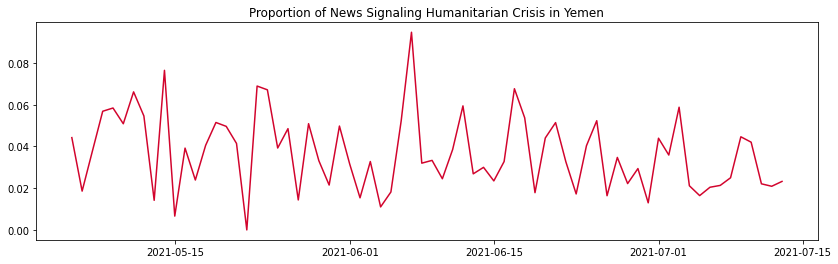

In [9]:
plt.figure(figsize=(14, 4))
plt.title('Proportion of News Signaling Humanitarian Crisis in Yemen')
plt.plot(yemen_df_grouped['mean'], color='#D2042D') ;



In [10]:
rollmean = yemen_df_grouped['mean'].rolling(window=7).mean()
rollstd = yemen_df_grouped['mean'].rolling(window=7).std()

Text(0.5, 1.0, 'Stationarity Check')

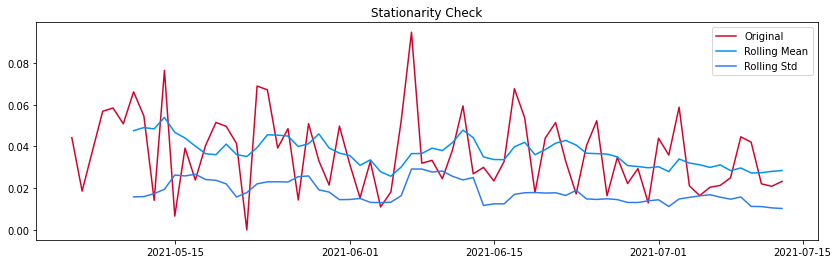

In [11]:
plt.figure(figsize=(14, 4))
original = plt.plot(yemen_df_grouped['mean'], color = '#D2042D', label = 'Original')
mean = plt.plot(rollmean, color = '#0092F4', label = 'Rolling Mean')
std = plt.plot(rollstd, color = '#2D7DF1', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Stationarity Check')


In [12]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fullter Test:')
dftest = adfuller(yemen_df_grouped['mean'], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
for k, v in dftest[4].items():
  dfoutput[f'Critiical Values: {k}'] = v

dfoutput

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey-Fullter Test:


Test Statistic          -6.052363e+00
p-value                  1.268631e-07
# Lags Used              1.000000e+00
# of Obs Used            6.800000e+01
Critiical Values: 1%    -3.530399e+00
Critiical Values: 5%    -2.905087e+00
Critiical Values: 10%   -2.590001e+00
dtype: float64

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

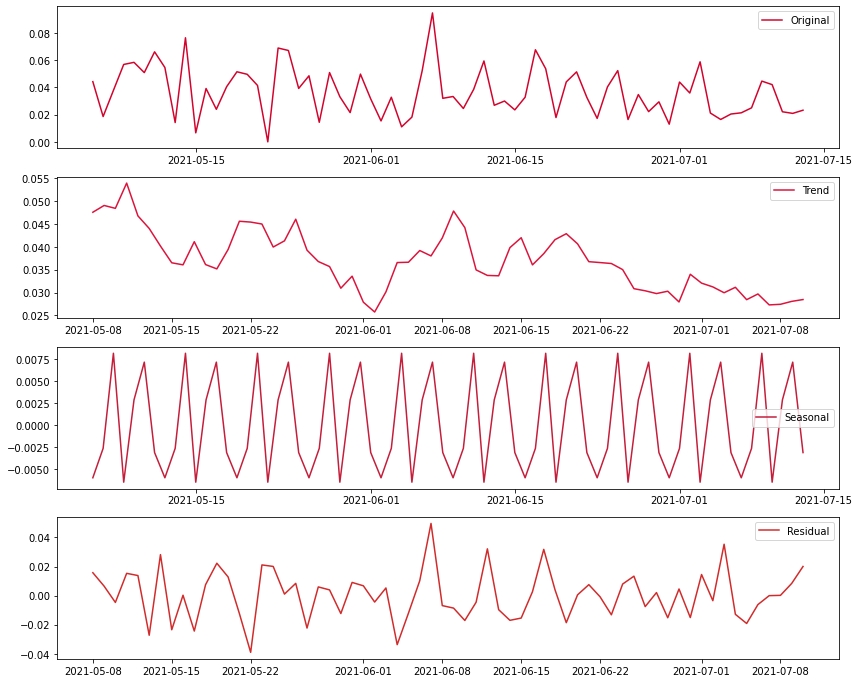

In [14]:
decomposition = seasonal_decompose(yemen_df_grouped['mean'])
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14,12))
plt.subplot(411)
plt.plot(yemen_df_grouped['mean'], label = 'Original', color = '#D2042D')
plt.legend()
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = '#DC143C')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal', color = '#C41E3A')
plt.legend()
plt.subplot(414)
plt.plot(residual, label = 'Residual', color = '#D22B2B')
plt.legend()

In [49]:
def test_stationarity(df, window=7, colors=['#D2042D', '#79B1E0', '#0092F4']):

  print('Results of Dickey-Fullter Test on Residual:')
  dftest = adfuller(df, autolag = 'AIC')

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
  for k, v in dftest[4].items():
    dfoutput[f'Critiical Values: {k}'] = v

  print(dfoutput)

  rollmean = decomposed_residual.rolling(window=window).mean()
  rollstd = decomposed_residual.rolling(window=window).std()

  plt.figure(figsize=(14, 4))
  original = plt.plot(decomposed_residual, color = colors[0], label = 'Residual')
  mean = plt.plot(rollmean, color = colors[1], label = 'Rolling Mean')
  std = plt.plot(rollstd, color = colors[2], label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Stationarity Check')
  plt.show()


Results of Dickey-Fullter Test on Residual:
Test Statistic          -6.379657e+00
p-value                  2.238618e-08
# Lags Used              6.000000e+00
# of Obs Used            5.700000e+01
Critiical Values: 1%    -3.550670e+00
Critiical Values: 5%    -2.913766e+00
Critiical Values: 10%   -2.594624e+00
dtype: float64


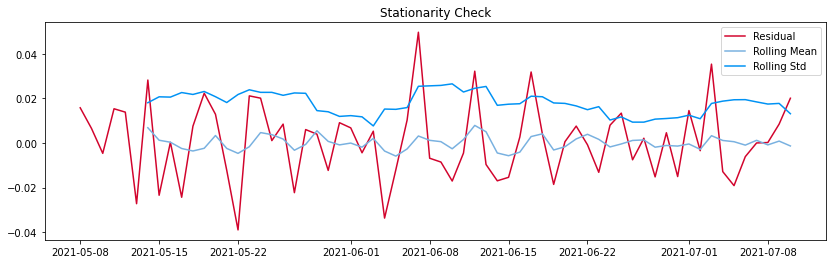

In [50]:
decomposed_residual = residual.dropna()

test_stationarity(decomposed_residual, window=7,  colors=['#D2042D', '#79B1E0', '#0092F4'])



Results of Dickey-Fullter Test on Residual:
Test Statistic          -6.355844e+00
p-value                  2.544117e-08
# Lags Used              5.000000e+00
# of Obs Used            6.300000e+01
Critiical Values: 1%    -3.538695e+00
Critiical Values: 5%    -2.908645e+00
Critiical Values: 10%   -2.591897e+00
dtype: float64


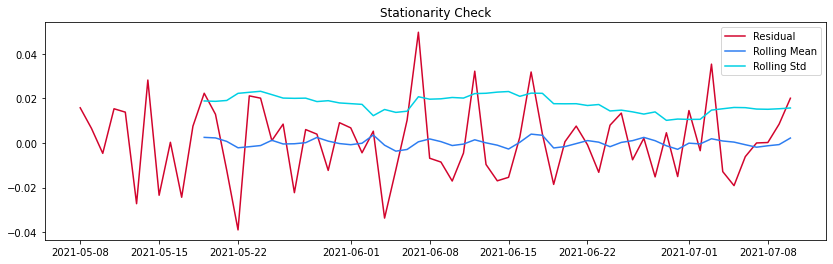

In [52]:
first_diff = yemen_df_grouped['mean'] - yemen_df_grouped['mean'].shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12, colors=['#D2042D', '#2D7DF1', '#00D0E4'])

In [54]:
from scipy import stats

(mu, sigma) = stats.norm.fit(decomposed_residual)

Text(0.5, 1.0, 'Residual distribution')

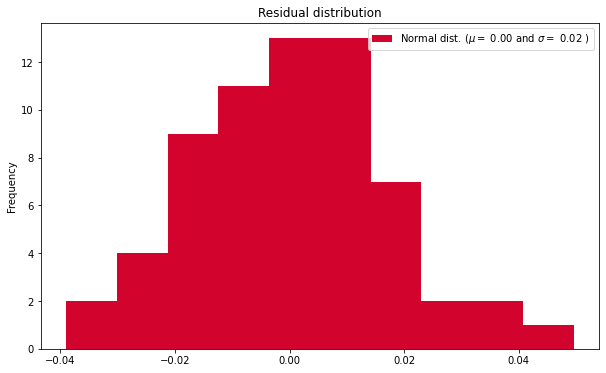

In [58]:
plt.figure(figsize=(10,6))
plt.hist(decomposed_residual, color='#D2042D')
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')